# Resampling timeseries using `eat`

In this tutorial, we demonstrate how `eat` can be used to easily resample timeseries.

First of all, the lib as well as other thirst-party ones are imported.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = True
pd.set_option('display.max_rows', 10)

import energy_analysis_toolbox as eat
import energy_analysis_toolbox.pandas
eat.__version__

'0.0.1'

## Resampling power data

First, this section shows how power data can be resampled. This is a very important operation as power data conveys information about the energy used on a certain site.

In general, power data is represented as a timeseries where each row contains the average power on the interval starting at the row index and lasting until the next row.
Accordingly, in order to avoid breaking energy conservation, between the source and the target data, the power should be resampled cautiously.
The method in `eat` ensures that for each interval in the resampled data, the energy contained is the same as which that was contained on the same interval according to the initial sampling.

This section illustrates how easily the resampling can be done using `eat`: users do not have to bother about the right way of ensuring energy conservation as this is directly handled by the provided functionality. 

### Example data
In this example, the time series is randomly generated.

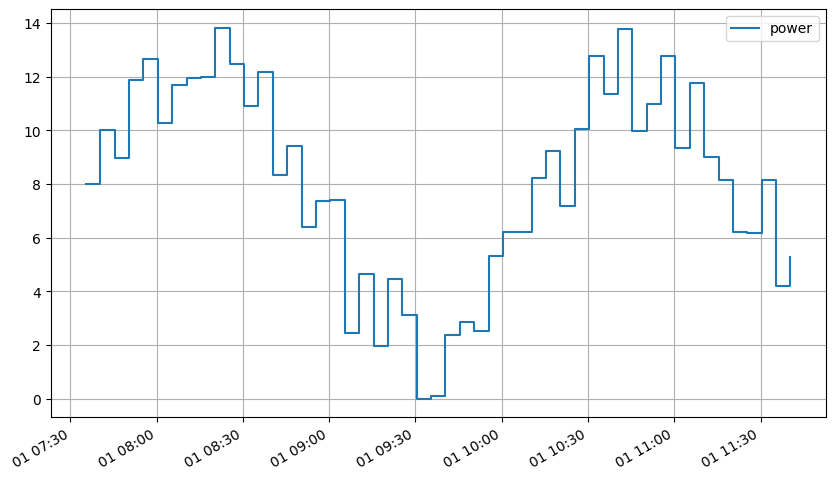

In [2]:
sample_power = pd.DataFrame(
    {"power": (np.random.randint(0, 5, 50)
               + 5 * np.sin(np.linspace(0, 10, 50)) + 5
               )
     },
    index=pd.date_range("2019-01-01 07:35:25", periods=50, freq="5min"),
)
sample_power.plot(drawstyle="steps-post");

### Upsampling

The simplest case it to upsample the power data. It correspond a "fill forward", as the flow is considered to be constant over the period between two instants.



In [3]:
sample_power_1min = eat.power.to_freq(sample_power["power"], "2.5min")

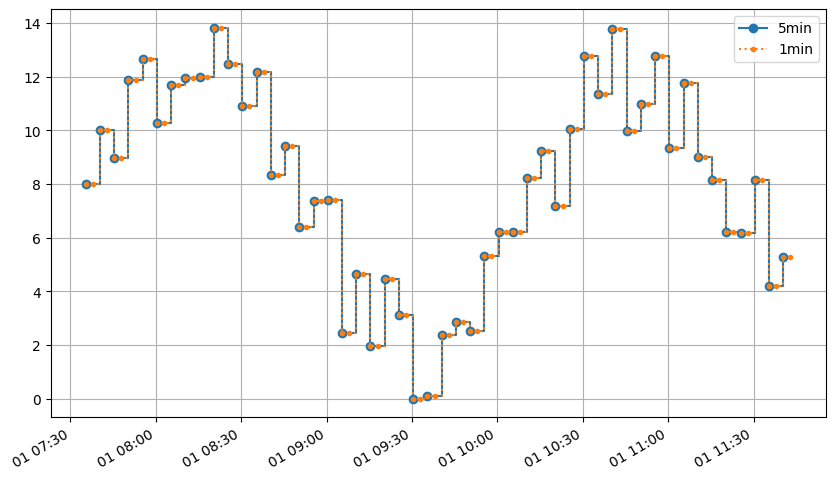

In [4]:
ax = sample_power.plot(drawstyle="steps-post", marker="o")
sample_power_1min.plot(drawstyle="steps-post", ax=ax, marker=".", ls=":")
ax.legend(["5min", "1min"]);

In [5]:
initial_total_energy = eat.power.to_energy(sample_power["power"]).sum()
resampled_total_energy = eat.power.to_energy(sample_power_1min).sum()
print(f"Initial total energy: {initial_total_energy:.2f} kWh")
print(f"Resampled total energy: {resampled_total_energy:.2f} kWh")
print(f"Ratio: {resampled_total_energy / initial_total_energy:.2%}")

Initial total energy: 120762.21 kWh
Resampled total energy: 120762.21 kWh
Ratio: 100.00%


### Downsampling 

Using the same function, the power can be resampled to a coarser period, e.g. 30min.
The obtained result is a time-averaged power during each 30min time-slot, as if the data came from an Enedis connector.

In [6]:
sample_power_30min = eat.power.to_freq(sample_power["power"], "30min")
sample_power_30min

2019-01-01 07:35:25    10.296045
2019-01-01 08:05:25    12.138581
2019-01-01 08:35:25     8.519530
2019-01-01 09:05:25     2.773721
2019-01-01 09:35:25     3.224594
2019-01-01 10:05:25     8.943146
2019-01-01 10:35:25    11.368231
2019-01-01 11:05:25     8.248519
2019-01-01 11:35:25     1.577750
Freq: 30min, Name: power, dtype: float64

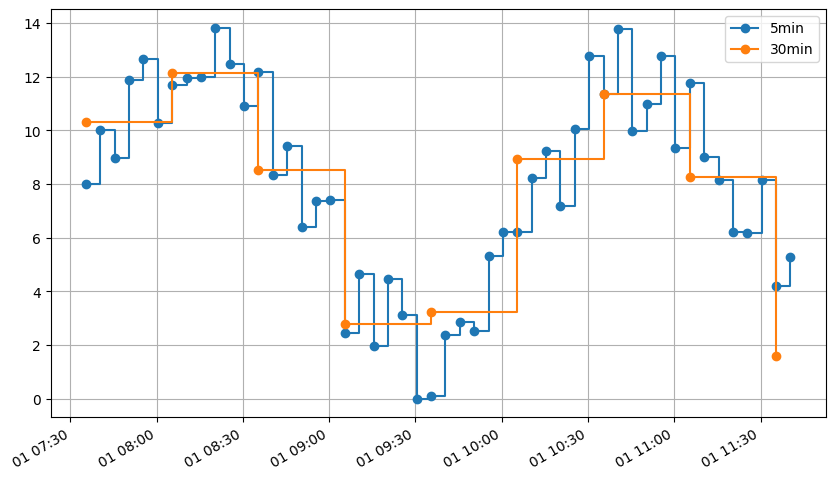

In [7]:
ax = sample_power.plot(drawstyle="steps-post", marker="o")
sample_power_30min.plot(drawstyle="steps-post", ax=ax, marker="o")
ax.legend(["5min", "30min"]);

In [8]:
resampled_total_energy = eat.power.to_energy(sample_power_30min).sum()
print(f"Initial total energy: {initial_total_energy:.2f} kWh")
print(f"Resampled total energy: {resampled_total_energy:.2f} kWh")
print(f"Ratio: {resampled_total_energy / initial_total_energy:.2%}")

Initial total energy: 120762.21 kWh
Resampled total energy: 120762.21 kWh
Ratio: 100.00%


### Changing the resampling default arguments

This section shows how to change the default arguments

#### Changing the Origin

The first timestep of the initial series is a bit arbitrary.
When resampling, it would make sens to have the new indexes aligned with the "whole frequency"

In [9]:
sample_power.index[0]

Timestamp('2019-01-01 07:35:25')

In [10]:
default_origin = eat.power.to_freq(sample_power["power"], "30min")
ceil_origin = eat.power.to_freq(sample_power["power"], "30min", origin="ceil")
floor_origin = eat.power.to_freq(sample_power["power"], "30min", origin="floor")
ts_origin = eat.power.to_freq(sample_power["power"], "30min", origin=sample_power.index[0] + pd.DateOffset(minute=25, second=0))

print(f"Default origin:   {default_origin.index[0]}")
print(f"Ceil origin:      {ceil_origin.index[0]} (start to the previous whole timestamp)" )
print(f"Floor origin:     {floor_origin.index[0]} (start to the next whole timestamp)")
print(f"Timestamp origin: {ts_origin.index[0]} (start to any arbitrary timestamp)")

Default origin:   2019-01-01 07:35:25
Ceil origin:      2019-01-01 08:00:00 (start to the previous whole timestamp)
Floor origin:     2019-01-01 07:30:00 (start to the next whole timestamp)
Timestamp origin: 2019-01-01 07:25:00 (start to any arbitrary timestamp)


In [11]:
sample_power.sum()

power    402.540707
dtype: float64

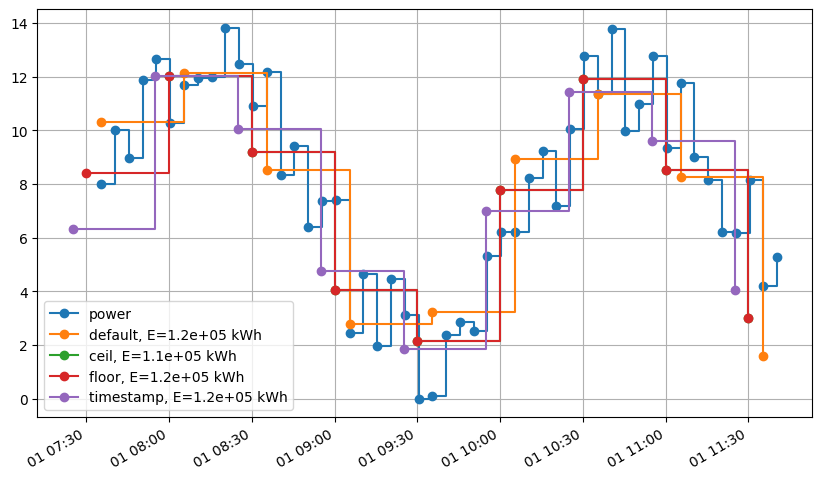

In [12]:
ax = sample_power.plot(
    drawstyle="steps-post",
    marker="o",
    label=f"initial, E={eat.power.to_energy(sample_power).sum()}",
)
default_origin.plot(
    drawstyle="steps-post",
    ax=ax,
    marker="o",
    label=f"default, E={eat.power.to_energy(default_origin).sum():.1e} kWh",
)
ceil_origin.plot(
    drawstyle="steps-post",
    ax=ax,
    marker="o",
    label=f"ceil, E={eat.power.to_energy(ceil_origin).sum():.1e} kWh",
)
floor_origin.plot(
    drawstyle="steps-post",
    ax=ax,
    marker="o",
    label=f"floor, E={eat.power.to_energy(floor_origin).sum():.1e} kWh",
)
ts_origin.plot(
    drawstyle="steps-post",
    ax=ax,
    marker="o",
    label=f"timestamp, E={eat.power.to_energy(ts_origin).sum():.1e} kWh",
)
ax.legend();

Depending of the relative position of the target first timestamp, and the initial first timestamp, the energy may not be conserved.

#### Changing the last timestep duration

By default, the last timestep duration is the same as the last timestep. 

In the scenarios where there is only one entry, or when the user wishes to change the last time duration, proceed as follow.


In [13]:
resampled_power_series = eat.power.to_freq(sample_power["power"], "30min", last_step_duration= pd.Timedelta(minutes=5).seconds)

### Conclusion about power resampling

As demonstrated in this notebook, `eat.power` offers a versatile and efficient way of resampling power timeseries.

## Resampling Energy data

Similarly, energy timeseries can be resampled using `eat.energy`.

In [14]:
sample_energy = eat.power.to_energy(sample_power["power"])

In [15]:
sample_energy_1min = eat.energy.to_freq(sample_energy, "1min")

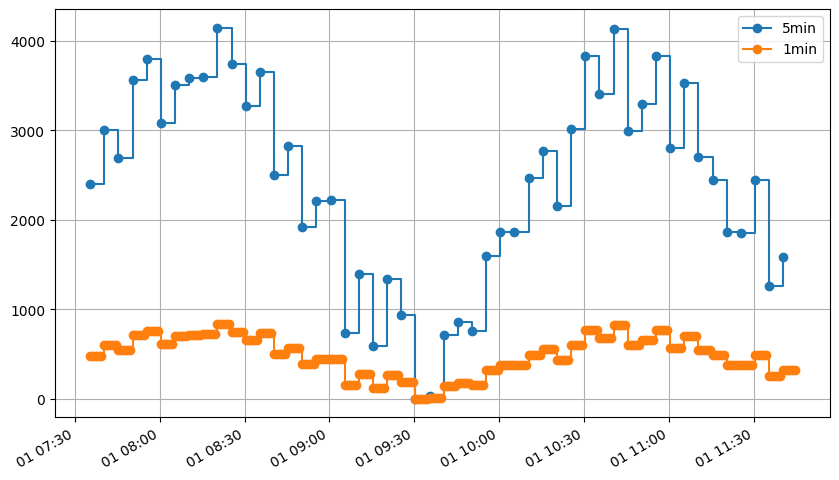

In [16]:
ax = sample_energy.plot(drawstyle="steps-post", marker="o")
sample_energy_1min.plot(drawstyle="steps-post", ax=ax, marker="o")
ax.legend(["5min", "1min"]);

In [17]:
initial_total_energy = sample_energy.sum()
resampled_total_energy = sample_energy_1min.sum()
print(f"Initial total energy: {initial_total_energy:.2f} kWh")
print(f"Resampled total energy: {resampled_total_energy:.2f} kWh")
print(f"Ratio: {resampled_total_energy / initial_total_energy:.2%}")

Initial total energy: 120762.21 kWh
Resampled total energy: 120762.21 kWh
Ratio: 100.00%


Initial total energy: 120762.21 kWh
Resampled total energy: 120762.21 kWh
Ratio: 100.00%


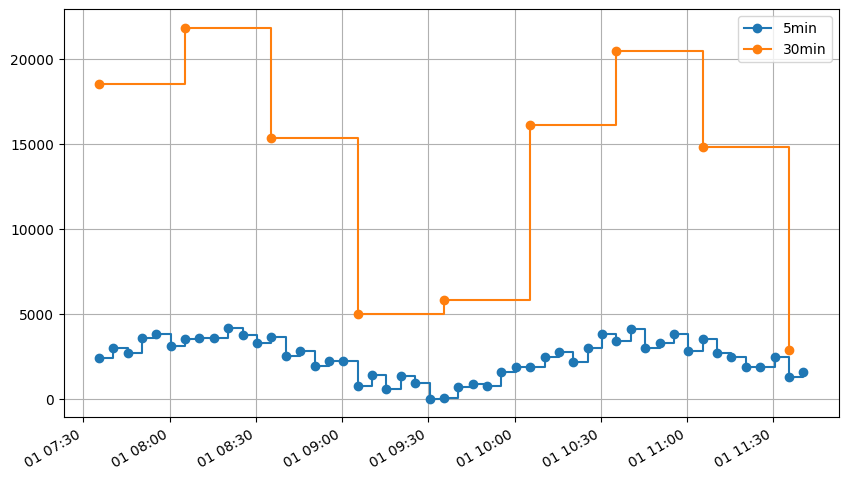

In [18]:
sample_energy_30min = eat.energy.to_freq(sample_energy, "30min")

ax = sample_energy.plot(drawstyle="steps-post", marker="o")
sample_energy_30min.plot(drawstyle="steps-post", ax=ax, marker="o")
ax.legend(["5min", "30min"])

resampled_total_energy = sample_energy_30min.sum()
print(f"Initial total energy: {initial_total_energy:.2f} kWh")
print(f"Resampled total energy: {resampled_total_energy:.2f} kWh")
print(f"Ratio: {resampled_total_energy / initial_total_energy:.2%}")

### Conclusion about energy resampling
As expected, the energy resampling preserve the energy between each indexes


## Resampling energy index data

An energy index is just a cumulated energy over time. 

While the energy as a timeseries is sampled as energy *over an interval*, the index is defined *at a certain time*.
The energy is sampled such that the value given at time $t$ is the energy used during the interval *starting at $t$* and finishing at the next index.

Accordingly, computing the index from the energy requires to shift the values one step ahead after the cumulated sum computation to obtain the value of the sum *at time t*.

In [19]:
sample_energy

2019-01-01 07:35:25    2400.000000
2019-01-01 07:40:25    3004.001905
2019-01-01 07:45:25    2695.386223
2019-01-01 07:50:25    3562.059062
2019-01-01 07:55:25    3792.952175
                          ...     
2019-01-01 11:20:25    1858.162973
2019-01-01 11:25:25    1855.521602
2019-01-01 11:30:25    2450.575809
2019-01-01 11:35:25    1255.982357
2019-01-01 11:40:25    1583.968334
Freq: 5min, Length: 50, dtype: float64

In [20]:
sample_index = sample_energy.cumsum().shift(1)
sample_index.iloc[0] = 0
sample_index

2019-01-01 07:35:25         0.000000
2019-01-01 07:40:25      2400.000000
2019-01-01 07:45:25      5404.001905
2019-01-01 07:50:25      8099.388128
2019-01-01 07:55:25     11661.447190
                           ...      
2019-01-01 11:20:25    111758.001141
2019-01-01 11:25:25    113616.164115
2019-01-01 11:30:25    115471.685717
2019-01-01 11:35:25    117922.261526
2019-01-01 11:40:25    119178.243883
Freq: 5min, Length: 50, dtype: float64

Assuming the timestep is constant, an additional index can be added using the last energy value :

In [21]:
timestep = eat.timeseries.resample.index_transformation.estimate_timestep(sample_index, method="mean")

In [22]:
sample_index[sample_energy.index[-1] + pd.Timedelta(seconds=timestep)] = sample_index.loc[sample_energy.index[-1]] + sample_energy.iloc[-1]
sample_index

2019-01-01 07:35:25         0.000000
2019-01-01 07:40:25      2400.000000
2019-01-01 07:45:25      5404.001905
2019-01-01 07:50:25      8099.388128
2019-01-01 07:55:25     11661.447190
                           ...      
2019-01-01 11:25:25    113616.164115
2019-01-01 11:30:25    115471.685717
2019-01-01 11:35:25    117922.261526
2019-01-01 11:40:25    119178.243883
2019-01-01 11:45:25    120762.212217
Freq: 5min, Length: 51, dtype: float64

So we've got our index! Now let resample it !

Actually, resampling an index is quiet easy.
As the values are defined *at a point* and not *on an interval*, any usual interpolation method could be used, provided that the assumptions are relevant.
Most often, as no information is known about what happens during two index measures, the most reasonable assumption is that the index has increased linearly between the two measures.
*Accordingly, the right index interpolation method seems to be *piecewise-affine* interpolation.
This is very easily done using `eat`:

Below an example of over and subsmpling :

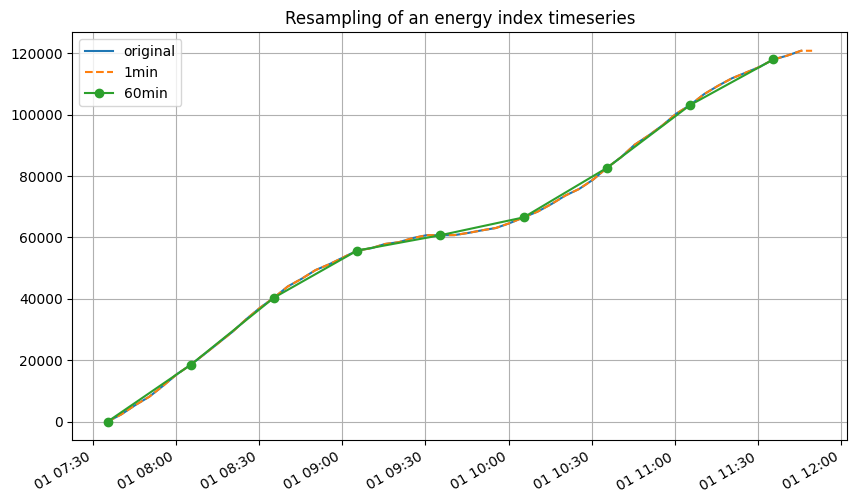

In [23]:
sample_index.plot(label='original', legend=True)
eat.timeseries.resample.to_freq(sample_index, freq="1min").plot(label="1min", legend=True, ls='--')
eat.timeseries.resample.to_freq(sample_index, freq="30min").plot(label="60min", legend=True, marker='o')
plt.title("Resampling of an energy index timeseries");

## Resampling temperature data

However, conversely to energy-related data, as temperature is sampled as "instantaneous values", the resampling :
- uses a piecewise affine interpolation method,
- returns `NA` values outside the boundaries of the initial data.

### Example data

The temperature data below comes from indoor temperature measures located on the same site as the power used in the previous example, for an overlapping time-period.

In [24]:
sample_temperature = pd.read_parquet('./data/sample_temperature_measures.parquet')["value"]
sample_temperature

timestamp
2023-03-21 00:02:03+01:00    18.6
2023-03-21 00:12:03+01:00    18.7
2023-03-21 00:22:03+01:00    18.7
2023-03-21 00:32:04+01:00    18.7
2023-03-21 00:42:04+01:00    18.7
                             ... 
2023-03-22 23:12:10+01:00    19.2
2023-03-22 23:22:10+01:00    19.2
2023-03-22 23:32:10+01:00    19.2
2023-03-22 23:42:10+01:00    19.1
2023-03-22 23:52:10+01:00    19.1
Name: value, Length: 287, dtype: float64

### Simple over or sub-sampling

The following illustrates simple over-sampling and sub-sampling.
Temperature may be interpolated/resampled in different ways depending on the needs and assumption.

Oversampling might be done using a piecewise affine or piecewise constant method. In this example, given the resolution of the data, there is not much difference.

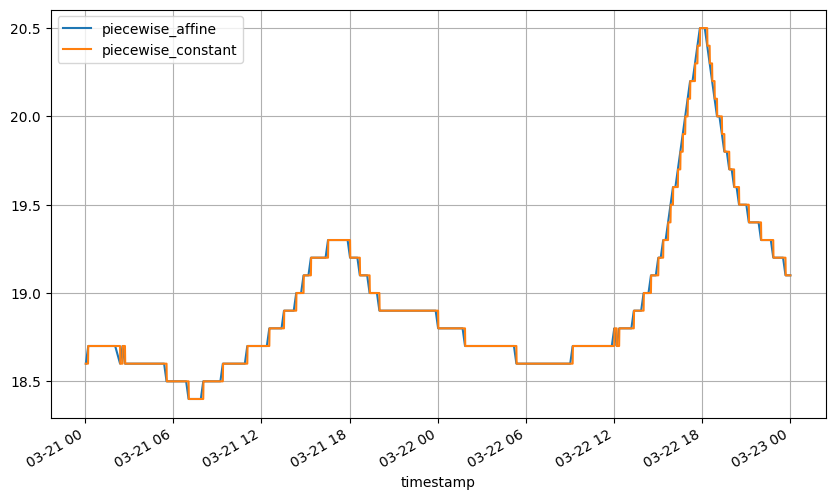

In [25]:
eat.timeseries.resample.to_freq(sample_temperature, "1min", method='piecewise_affine').plot(
    label='piecewise_affine', legend=True);
eat.timeseries.resample.to_freq(sample_temperature, "1min", method='piecewise_constant').plot(
    label='piecewise_constant', legend=True);

Subsamping can also be done the same way :

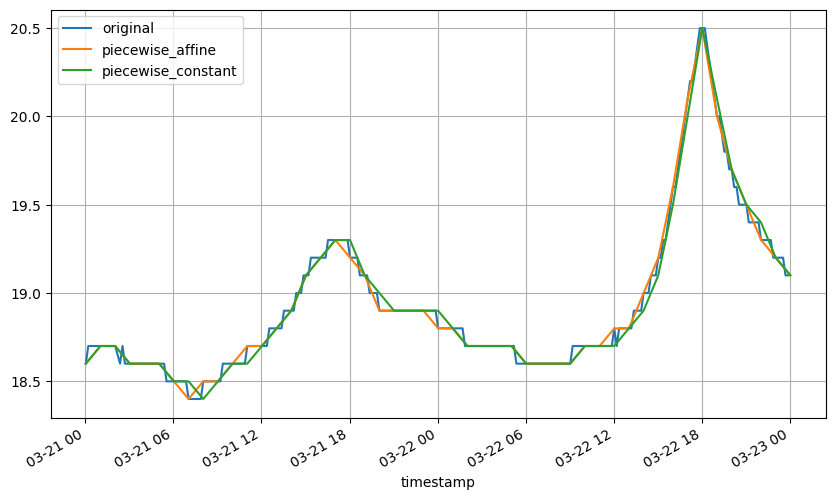

In [26]:
sample_temperature.plot(label='original', legend=True)
eat.timeseries.resample.to_freq(sample_temperature, "60min", method='piecewise_affine').plot(
    label='piecewise_affine', legend=True)
eat.timeseries.resample.to_freq(sample_temperature, "60min", method='piecewise_constant').plot(
    label='piecewise_constant', legend=True);

If one wish to compute a resampled mean temperature but the sampling rate of the original data is irregular, it is better to first oversample with a correct assumption then resample and compute the average.
Below, using the [`eat` extension for `pandas` series](http://recherche.gitlab-pages.ecoco2.com/energy_toolbox/html/sources/energy_toolbox.pandas.html):

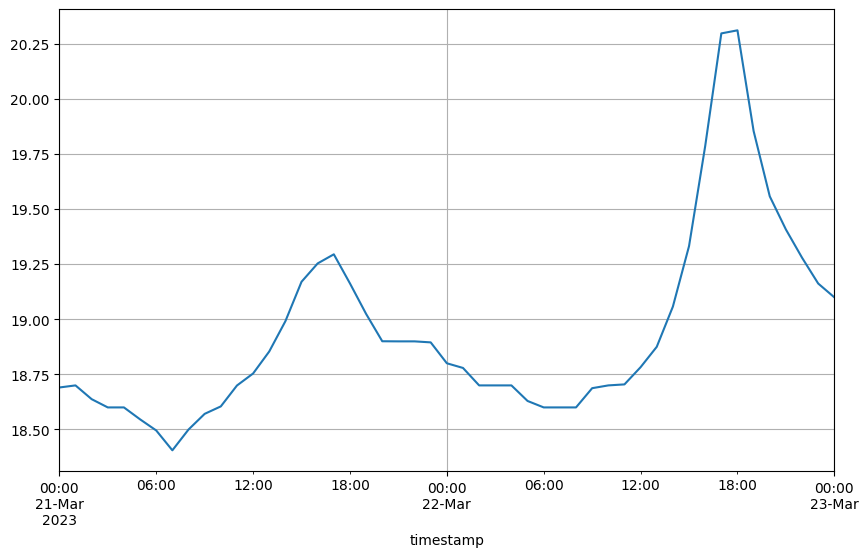

In [27]:
sample_temperature.eat.to_freq("1min", method='piecewise_affine').resample('60min').mean().plot();